In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pprint

from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import HistoricalData
import yfinance as yf

In [2]:
plt.style.use("fivethirtyeight")
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["font.family"] = "serif"
np.set_printoptions(precision=5, suppress=True, formatter={"float": lambda x: f"{x:6.3f}"})

# First portfolio

we want to measure the performance of a portfolio consisting of Google, Apple, Microsoft, Netflix and Amazon stocks if we had invested in it from 2012 to early 2021. .

In [43]:
SYMBOLS_1 = ["GOOG", "AAPL", "MSFT", "NFLX", "AMZN"]

In [44]:
close_data_1 = pd.read_csv('close_data_1.csv', usecols=SYMBOLS_1)
close_data_1.head(2)

,AMZN,MSFT,AAPL,NFLX,GOOG
0,179.029999,26.77,14.686786,10.320000,331.462585
1,177.509995,27.40,14.765714,11.492857,332.892242


In [4]:
close_data_1['Date'] = pd.to_datetime(close_data_1['Date'])

In [5]:
close_data_1.set_index('Date', inplace=True)

In [10]:
close_data_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2012-01-03 to 2020-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    2265 non-null   float64
 1   MSFT    2265 non-null   float64
 2   AAPL    2265 non-null   float64
 3   NFLX    2265 non-null   float64
 4   GOOG    2265 non-null   float64
dtypes: float64(5)
memory usage: 106.2 KB


In [6]:
monthly_data_1 = close_data_1.resample("M").ffill().pct_change()

In [11]:
monthly_data_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2012-01-31 to 2020-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    107 non-null    float64
 1   MSFT    107 non-null    float64
 2   AAPL    107 non-null    float64
 3   NFLX    107 non-null    float64
 4   GOOG    107 non-null    float64
dtypes: float64(5)
memory usage: 5.1 KB


The resampling will be performed with the resample("M") method and the calculation of percentages with the pct_change() method. The result will be stored in the monthly_data_1 variable.

In [7]:
monthly_data_1.mean()

AMZN    0.029931
MSFT    0.020698
AAPL    0.023033
NFLX    0.042060
GOOG    0.018784
dtype: float64

### Important

*Remember that this closing information represents the relative growth of each stock, not its closing price in any currency.*

As we can see, all the results are positive, so this portfolio has been profitable over the years. In relative terms, the biggest gains would come from Netflix (0.4 percent). These percentages show an average of the monthly variation of the stock price. But how stable have that prices been?

In [8]:
monthly_data_1.std()

AMZN    0.082308
MSFT    0.058395
AAPL    0.081239
NFLX    0.145416
GOOG    0.061057
dtype: float64

The highest volatility is found in Netflix (0.1454), which indicates that its price, despite being the fastest growing, has also had a lot of variation during these years. The most stable price, on the other hand, has been Microsoft’s (0.0583).

***

A good way to observe both growth and variability is to draw a time-series plot. To scale the values, we are going to divide the relative frequency of the closing price of the actions by the initial value it has in the dataframe close_data_1 (these initial values can be found with close_data_1.iloc[0])).

<Axes: title={'center': 'Portfolio 1 daily stock price'}, xlabel='Date'>

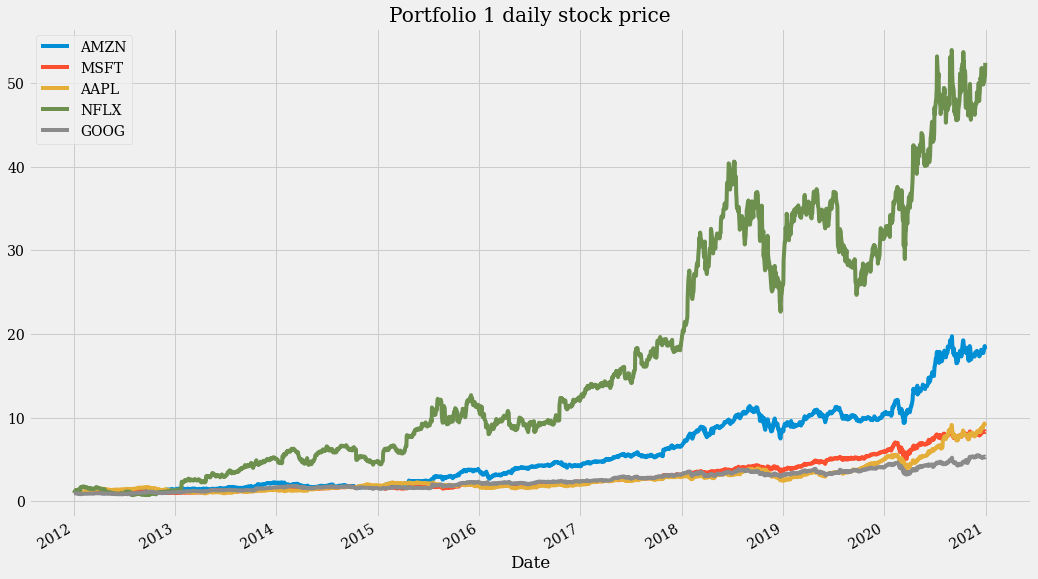

In [14]:
(close_data_1/close_data_1.iloc[0]).plot(figsize=(16, 10), 
      title="Portfolio 1 daily stock price")

<Axes: title={'center': 'Portfolio 1 monthly stock price'}, xlabel='Date'>

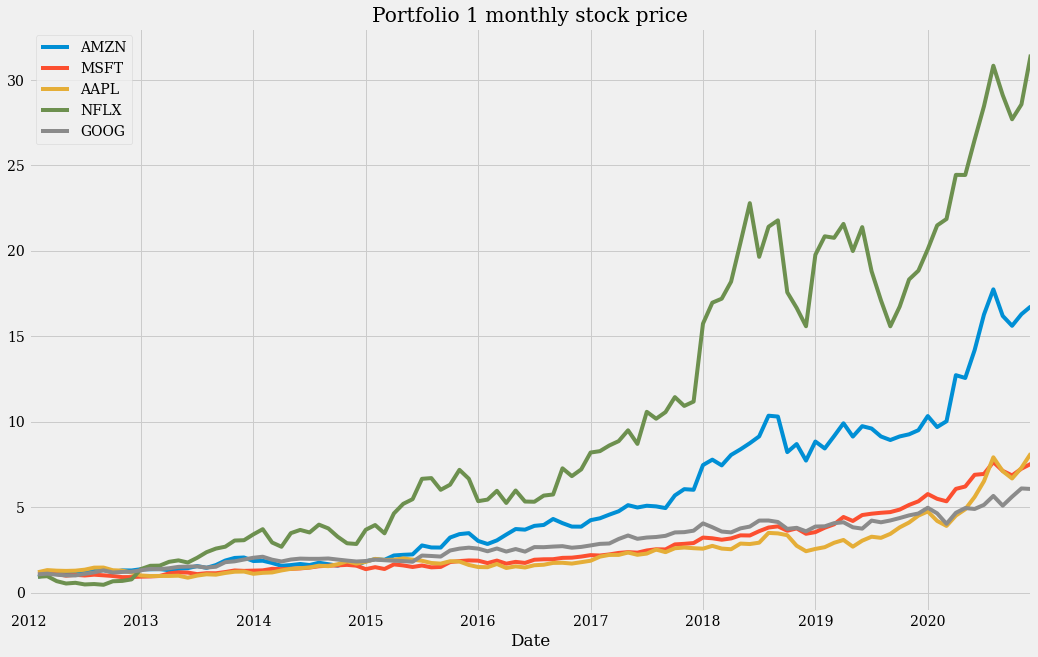

In [16]:
(monthly_data_1 + 1).cumprod().plot(figsize=(16, 10), title="Portfolio 1 monthly stock price")

This plot of the monthly data is “smoother” than the plot of the daily data.

### information

The .cumprod() function can be useful in various scenarios, particularly in finance, economics, and data analysis. Here are a few reasons why you might want to use it:

- Calculating cumulative returns: In finance, it is common to calculate the cumulative returns of an investment or portfolio over a certain period. By using .cumprod() on a series of investment returns, you can obtain the cumulative growth of the investment over time. This can help in analyzing the performance and growth trajectory of investments.

- Calculating compounded growth: When dealing with growth rates or percentages, the cumulative product can be used to calculate the compounded growth over a period. By applying .cumprod() to a series of growth rates, you can obtain the cumulative compounded growth factor, which represents the overall growth or decline over time.

- Time series analysis: Time series data often requires calculations involving cumulative values. .cumprod() can be used to compute cumulative sums or products of various indicators or variables over time, providing insights into the evolving trends or patterns in the data.

- Simulation and forecasting: In certain simulation or forecasting scenarios, it may be necessary to generate multiple possible future outcomes based on a given set of probabilities or scenarios. By applying .cumprod() to a series of probabilities or growth rates, you can generate simulated future paths for variables that compound over time.

Overall, the .cumprod() function enables you to analyze the cumulative behavior and growth of values over time, making it a valuable tool for a range of analytical tasks in finance, economics, and data analysis.

## Returns and volatility
Remember that in *the mean-variance portfolio theory* what matters are the expected returns and variances. To calculate these returns, we will divide the price of the stock on one day by the price of the same stock on the previous day. We will do this by dividing the close_data_1 DataFrame by a version of itself in which we shift each record one date backwards (shift(1)). 

For example, if on the date 2012-01-03 a stock was valued at 1, and on the next day (2012-01-02), it was valued at 2, then in our shifted dataset, on the day 2012-01-03 the stock would be worth 1. In this way, we would divide 1 by 2. And so on with all the values of all the shares. We will also normalize the results by passing them to a logarithmic scale with np.log().

In [31]:
rets_1 = np.log(close_data_1/close_data_1.shift(1)).dropna()

In [32]:
rets_1.head()

,AMZN,MSFT,AAPL,NFLX,GOOG
Date,,,,,
2012-01-04,-0.008526,0.023261,0.005360,0.107642,0.004304
2012-01-05,0.000563,0.010167,0.011041,-0.014398,-0.013969
2012-01-06,0.027763,0.015415,0.010400,0.084476,-0.013736
2012-01-09,-0.022428,-0.013250,-0.001587,0.129089,-0.043324
2012-01-10,0.004359,0.003598,0.003574,-0.024227,0.001092


there are positive values (the share price increased) and negative values (the price decreased at the time of closing).

In addition to the returns of each stock, we will need the specific weight of each stock in the portfolio, i.e., how many shares of each company are in the portfolio. In this workshop we will assume that there is one share of each company and, therefore, the weights will be distributed equally.

*A stock is a financial security that represents that you own a part of a company (whatever the size of this part). A share, on the other hand, is the smallest unit of denomination of a stock. A stock is composed of one or several shares.*

This weight will be a vector (Python list) composed of the relative weight (between 0 and 1) of each stock in the portfolio. The sum of these weights has to be 1. Since we will assume that each stock is a single share, the distribution will be equal: [0.2, 0.2, 0.2, 0.2, 0.2].

In [33]:
weights_1 = [0.2, 0.2, 0.2, 0.2, 0.2]

With this information we can calculate the expected return of this portfolio. The math is simple: this is given by the dot product of the portfolio weights vector and the vector of expected returns. This result must be multiplied by the number of days for which the return is to be calculated (a year has approximately 252 stock price closings).

In [34]:
def portfolio_return(returns, weights):
    return np.dot(returns.mean(), weights) * 252

In [35]:
portfolio_return(rets_1, weights_1)

0.28590660236063414

An expected gain of almost 30% in one year. Not bad, right? But don’t forget the other side of this coin: volatility. This calculation is a bit more complex. 

First, the dot product of the annualized covariance of the returns (this is multiplied by the number of trading days in a year) and the weights is calculated. 

Then the dot product of the weights and the previous result is obtained. 

Finally, the square root of this result is extracted. Let’s implement this into a function as well.

In [36]:
def portfolio_volatility(returns, weights):
    return np.dot(weights, np.dot(returns.cov() * 252, weights)) ** 0.5

In [37]:
portfolio_volatility(rets_1, weights_1)

0.23704031354688784

If high return is desirable, high volatility is undesirable. The risk of this portfolio is relatively large.

## Sharpe ratio

The Sharpe ratio or index is a measure of portfolio performance. It relates the portfolio’s return to its volatility, comparing the expected/realized return with the expected/realized risk. 

It is calculated as the difference between the actual investment returns and the expected return in a zero-risk situation, divided by the volatility of the investment. It provides a model of the additional amount of returns received for each additional unit of risk.

In [39]:
def portfolio_sharpe(returns, weights):
    return portfolio_return(returns, weights) / portfolio_volatility(returns, weights)

In [40]:
portfolio_sharpe(rets_1, weights_1)

1.206151806342765

### Important

The Sharpe ratio measure is best understood in context: when comparing two or more portfolios, the one with the higher Sharpe ratio provides more profit for the same amount of risk.

We can also use a Monte Carlo simulation to randomize the weights of each stock in the portfolio so that we can see the range over which the Sharpe ratio can vary. In this way we can plot some scenarios that together will give us a good insight of the relationship between expected returns and expected volatility.

We are going to do this with a function that we will explain step by step in the monte_carlo_sharpe function explained section.

In [41]:
def monte_carlo_sharpe(returns, symbols, weights):

    sim_weights = np.random.random((1000, len(symbols)))
    sim_weights = (sim_weights.T / sim_weights.sum(axis=1)).T

    volat_ret = [(portfolio_volatility(returns[symbols], weights), portfolio_return(returns[symbols], weights)) for weights in sim_weights]
    volat_ret = np.array(volat_ret)

    sharpe_ratio = volat_ret[:, 1] / volat_ret[:, 0]

    return volat_ret, sharpe_ratio

### monte_carlo_sharpe function explained

Let’s now break the function down to understand what is happening. First, we create a numpy array of length 1,000 and width of the number of shares in the portfolio. Each row of the array has random weights that always add up to 1:
```
sim_weights = np.random.random((1000, len(symbols)))
sim_weights = (sim_weights.T / sim_weights.sum(axis=1)).T `
```
The next section calculates the volatility and returns for the new random weights using a list comprehension. The resulting list is transformed back into a numpy array:
```
volat_ret = [(portfolio_volatility(returns[symbols], weights), portfolio_return(returns[symbols], weights)) for weights in sim_weights]
volat_ret = np.array(volat_ret)
```
Finally, we obtain the Sharpe ratio by dividing the index 1 (volatilities) by the index 0 (returns) of the numpy array:
```
sharpe_ratio = volat_ret[:, 1] / volat_ret[:, 0]
```
Using the monte_carlo_sharpe function
We use the function to get the simulated returns and volatility of portfolio 1 (port_1_vr) and the related Sharpe ratios (port_1_sr).

In [45]:
port_1_vr, port_1_sr = monte_carlo_sharpe(rets_1, SYMBOLS_1, weights_1)

Text(0.5, 1.0, 'GOOG | AAPL | MSFT | NFLX | AMZN')

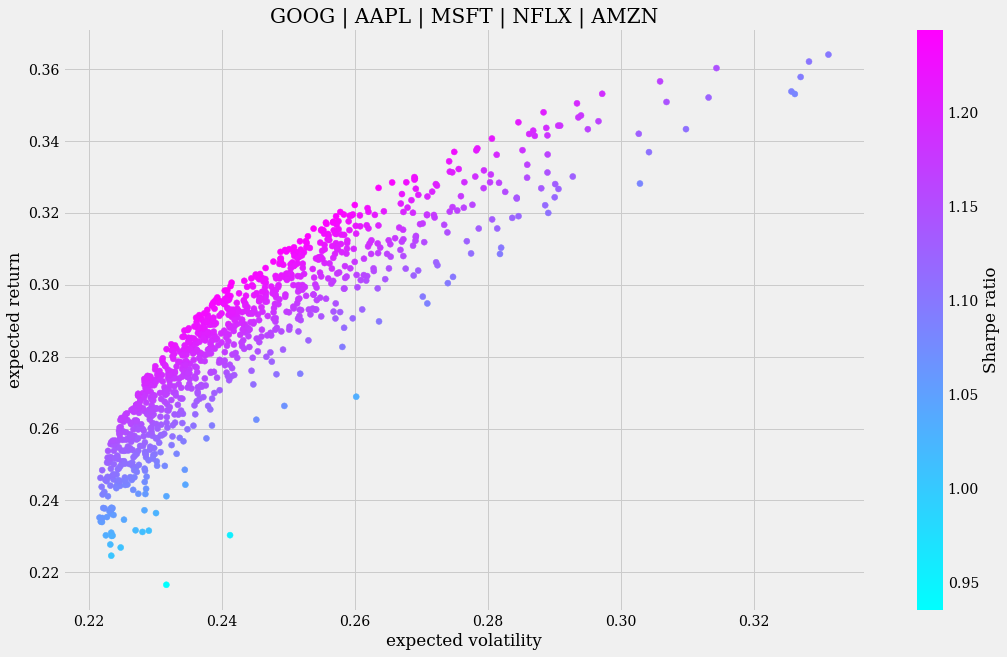

In [46]:
plt.figure(figsize=(16, 10))
fig = plt.scatter(port_1_vr[:, 0], port_1_vr[:, 1], c=port_1_sr, cmap="cool")
CB = plt.colorbar(fig)
CB.set_label("Sharpe ratio")
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.title(" | ".join(SYMBOLS_1))

A roughly linear relationship can be observed between returns and volatility: the higher the volatility, the higher the gains. And the Sharpe ratio shows an important amount of variability (it is noticeable in the “width” of the line drawn).

This seems to be a good portfolio because it has a good performance with a not very large variance.

## Optimal portfolio weights

Can we use the data obtained to calculate the optimal weights for the portfolio by year? Of course we can. Let’s start by delimiting the previous years as variables.

In [47]:
start_year, end_year = (2012, 2020)

In [48]:
def optimal_weights(returns, symbols, actual_weights, start_y, end_y):

    bounds = len(symbols) * [(0, 1), ]
    constraints = {"type": "eq", "fun": lambda weights: weights.sum() - 1}
    opt_weights = {}

    for year in range(start_y, end_y):
        _rets = returns[symbols].loc[f"{year}-01-01":f"{year}-12-31"]
        _opt_w = minimize(lambda weights: -portfolio_sharpe(_rets, weights), actual_weights, bounds=bounds, constraints=constraints)["x"]
        opt_weights[year] = _opt_w
    return opt_weights

Let’s describe this function in broad strokes. bounds indicates the maximum and minimum weights for each stock in the portfolio. The lowest weight will be 0 and the highest weight will be 1 for each stock in the portfolio. constraints is a function that ensures that the sum of the weights of all actions always adds up to 1. Then a loop is initialized that will segment the data for each year. 

In the variable _rets the returns for the specified year are obtained. In _opt_w the portfolio_shape() function is used to calculate the weights that maximize the Sharpe ratio. This is done with the minimize() function of SciPy (which takes as arguments the portfolio_shape function, the actual weights of our stocks in the portfolio, and the bounds and the constraints variables). Notice the - sign before portfolio_sharpe? It’s because minimize() aims to find the minimum value of a function relative to a parameter, but we are interested in the maximum, so we make the result of portfolio_sharpe a negative one.

We will use the function we just defined to calculate the optimal weights for each year, and we are going to save the result in a Pandas DataFrame to take advantage of the Variable Explorer display options.

In [49]:
opt_weights_1 = optimal_weights(rets_1, SYMBOLS_1, weights_1, start_year, end_year)
port_1_ow = pd.DataFrame.from_dict(opt_weights_1, orient='index')
port_1_ow.columns = SYMBOLS_1

In [52]:
port_1_ow.style.background_gradient()

,GOOG,AAPL,MSFT,NFLX,AMZN
2012,0.000000,0.420838,0.000000,0.005904,0.573258
2013,0.405178,0.084941,0.190244,0.208245,0.111392
2014,0.000000,0.569095,0.430905,0.000000,0.000000
2015,0.000000,0.000000,0.000000,0.253553,0.746447
2016,0.000000,0.312053,0.558626,0.000000,0.129321
2017,0.045935,0.346229,0.342781,0.072140,0.192915
2018,0.000000,0.000000,0.115391,0.455318,0.429291
2019,0.000000,0.499389,0.500611,0.000000,0.000000


You can see, for example, how 2015 was a particularly good year for investing in Amazon and Netflix, while 2014 was the year of Apple. Despite Netflix’s rapid growth over the years, its high volatility means that its Sharpe Ratio is not very remarkable in any year, especially (as we said above) in 2014 and 2019. In the same respect, Apple and Microsoft seem to be safer bets in the return/volatility ratio.

## Comparison of expected and realized returns
 we will use the optimal weights to calculate the expected returns and compare them with the actual returns.

In [53]:
def exp_real_rets(returns, opt_weights, symbols, start_year, end_year):

    _rets = {}
    for year in range(start_year, end_year):
        prev_year = returns[symbols].loc[f"{year}-01-01":f"{year}-12-31"]
        current_year = returns[symbols].loc[f"{year + 1}-01-01":f"{year + 1}-12-31"]
        expected_pr = portfolio_return(prev_year, opt_weights[year])
        realized_pr = portfolio_return(current_year, opt_weights[year])
        _rets[year + 1] = [expected_pr, realized_pr]

    return _rets

In this function we compare year to year realized returns with theoretically expected returns. This is done by estimating:

- The returns from applying the optimal weights of the previous year’s stocks to the data for that same year (expected_pr).

- The returns from applying the optimal weights of the previous year’s stocks to the following year’s data (realized_pr).

In [54]:
port_1_exp_real = pd.DataFrame.from_dict(exp_real_rets(rets_1, opt_weights_1, SYMBOLS_1, start_year, end_year), orient='index')
port_1_exp_real.columns = ["expected", "realized"]

In [55]:
port_1_exp_real

,expected,realized
2013,0.307023,0.296072
2014,0.594104,-0.000080
2015,0.275422,0.049519
2016,0.796950,0.097600
2017,0.106596,0.355754
2018,0.373687,0.106736
2019,0.279712,0.226105
2020,0.530582,0.465897


The expected column shows the predicted values if the optimal portfolio composition had been used. The realized column, on the other hand, shows the actual profits that would have been obtained with those weights. It can be seen that there are notable differences in some years. Let’s look at this in a plot.

<Axes: title={'center': 'Expected vs. realized Portfolio Returns'}>

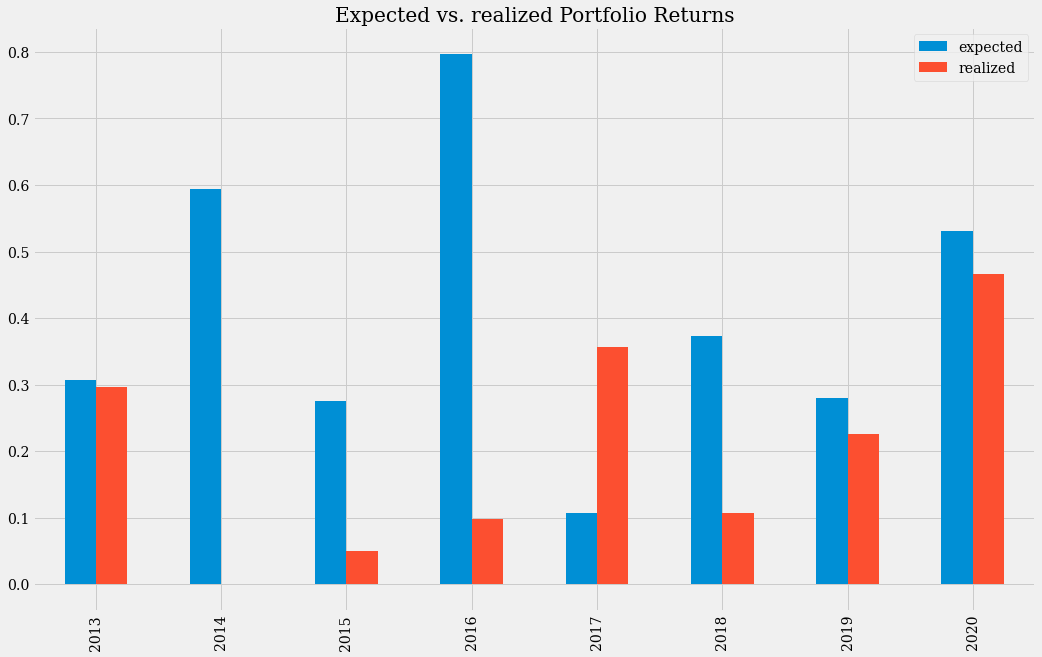

In [56]:
port_1_exp_real.plot(kind="bar", figsize=(16, 10),title="Expected vs. realized Portfolio Returns")


Our optimal weight model offered us a profit of around 40%, but the profit we would have obtained, due to real market fluctuations, would have been almost 20%. Not bad, but the mean-variance portfolio model we have applied for annual calculations is not very accurate, is it?

And this result is less encouraging if we calculate the correlations between expected and realized profits.

In [57]:
port_1_exp_real[["expected", "realized"]].corr()

,expected,realized
expected,1.000000,-0.324053
realized,-0.324053,1.000000


As we can see, the correlations are negative, which warns us that we should be cautious when using this type of modeling.